## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import CSV files

In [2]:
df1 = pd.read_csv("DataSet1.csv")
df2 = pd.read_csv("DataSet2.csv")
df3 = pd.read_csv("DataSet3.csv")

## Handle Values

In [3]:
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)
print(df2.isnull().sum())

#Add BMI column for dataset3
df3["Height (m)"] = df3["Height (cm)"] / 100
df3["BMI"] = df3["Weight (kg)"] / (df3["Height (m)"] ** 2)
df3["BMI"] = df3["BMI"].round(2)

# Drop unneccessary columns to reduce redundancy
df3 = df3[df3["Gender"] != "Other"]
df1 = df1.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df2 = df2.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df3 = df3.drop(columns=["User ID","Workout Type","Mood Before Workout","Mood After Workout","VO2 Max","Height (m)",
                        "Workout Intensity","Weight (kg)","Height (cm)","Water Intake (liters)","Body Fat (%)"])
df3.reset_index(drop=True, inplace=True)

# Encode Gender
df1['Gender'] = df1['Gender'].map({'Male': 0, 'Female': 1})
df2['Gender'] = df2['Gender'].map({'Male': 0, 'Female': 1})
df3['Gender'] = df3['Gender'].map({'Male': 0, 'Female': 1})

#Turn unncesary float number to integer Ex: age, frequency, level
df2["Age"] = df2["Age"].round(0).astype(int)
df2["Workout_Frequency (days/week)"] = df2["Workout_Frequency (days/week)"].round(0).astype(int)
df2["Experience_Level"] = df2["Experience_Level"].round(0).astype(int)
df2["Calories_Burnedl"] = df2["Calories_Burned"].round(0).astype(int)

df2['Max_BPM'] = pd.to_numeric(df2['Max_BPM'], errors='coerce')
df2['BMI'] = pd.to_numeric(df2['BMI'], errors='coerce')


Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64


In [4]:
df1.head()

,Age,Gender,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,0,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20
1,46,1,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00
2,32,1,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71
3,25,0,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41
4,38,0,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39


In [5]:

df2.head()


,Age,Gender,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Calories_Burnedl
0,34,1,174.0,152.0,74.0,1.12,712.0,12.8,2.4,5,2,14.31,712
1,26,1,166.0,156.0,73.0,1.00,833.0,27.9,2.8,5,2,33.49,833
2,22,0,187.0,166.0,64.0,1.24,1678.0,28.7,1.9,3,2,12.73,1678
3,54,1,187.0,169.0,58.0,1.45,628.0,31.8,2.4,4,1,20.37,628
4,34,1,177.0,169.0,66.0,1.60,1286.0,26.4,3.2,4,2,20.83,1286


In [6]:

df3.head()

,Age,Gender,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Sleep Hours,Daily Calories Intake,Resting Heart Rate (bpm),BMI
0,39,0,79,384,112,8850,14.44,8.2,3195,61,32.33
1,25,1,27,540,133,18898,7.28,9.8,3362,80,20.37
2,56,0,39,672,118,14102,6.55,5.8,2071,65,37.53
3,33,0,11,301,142,10895,6.53,4.2,2401,69,30.86
4,48,1,109,351,114,4687,6.47,4.3,2310,72,35.96


## Confusion Matrix

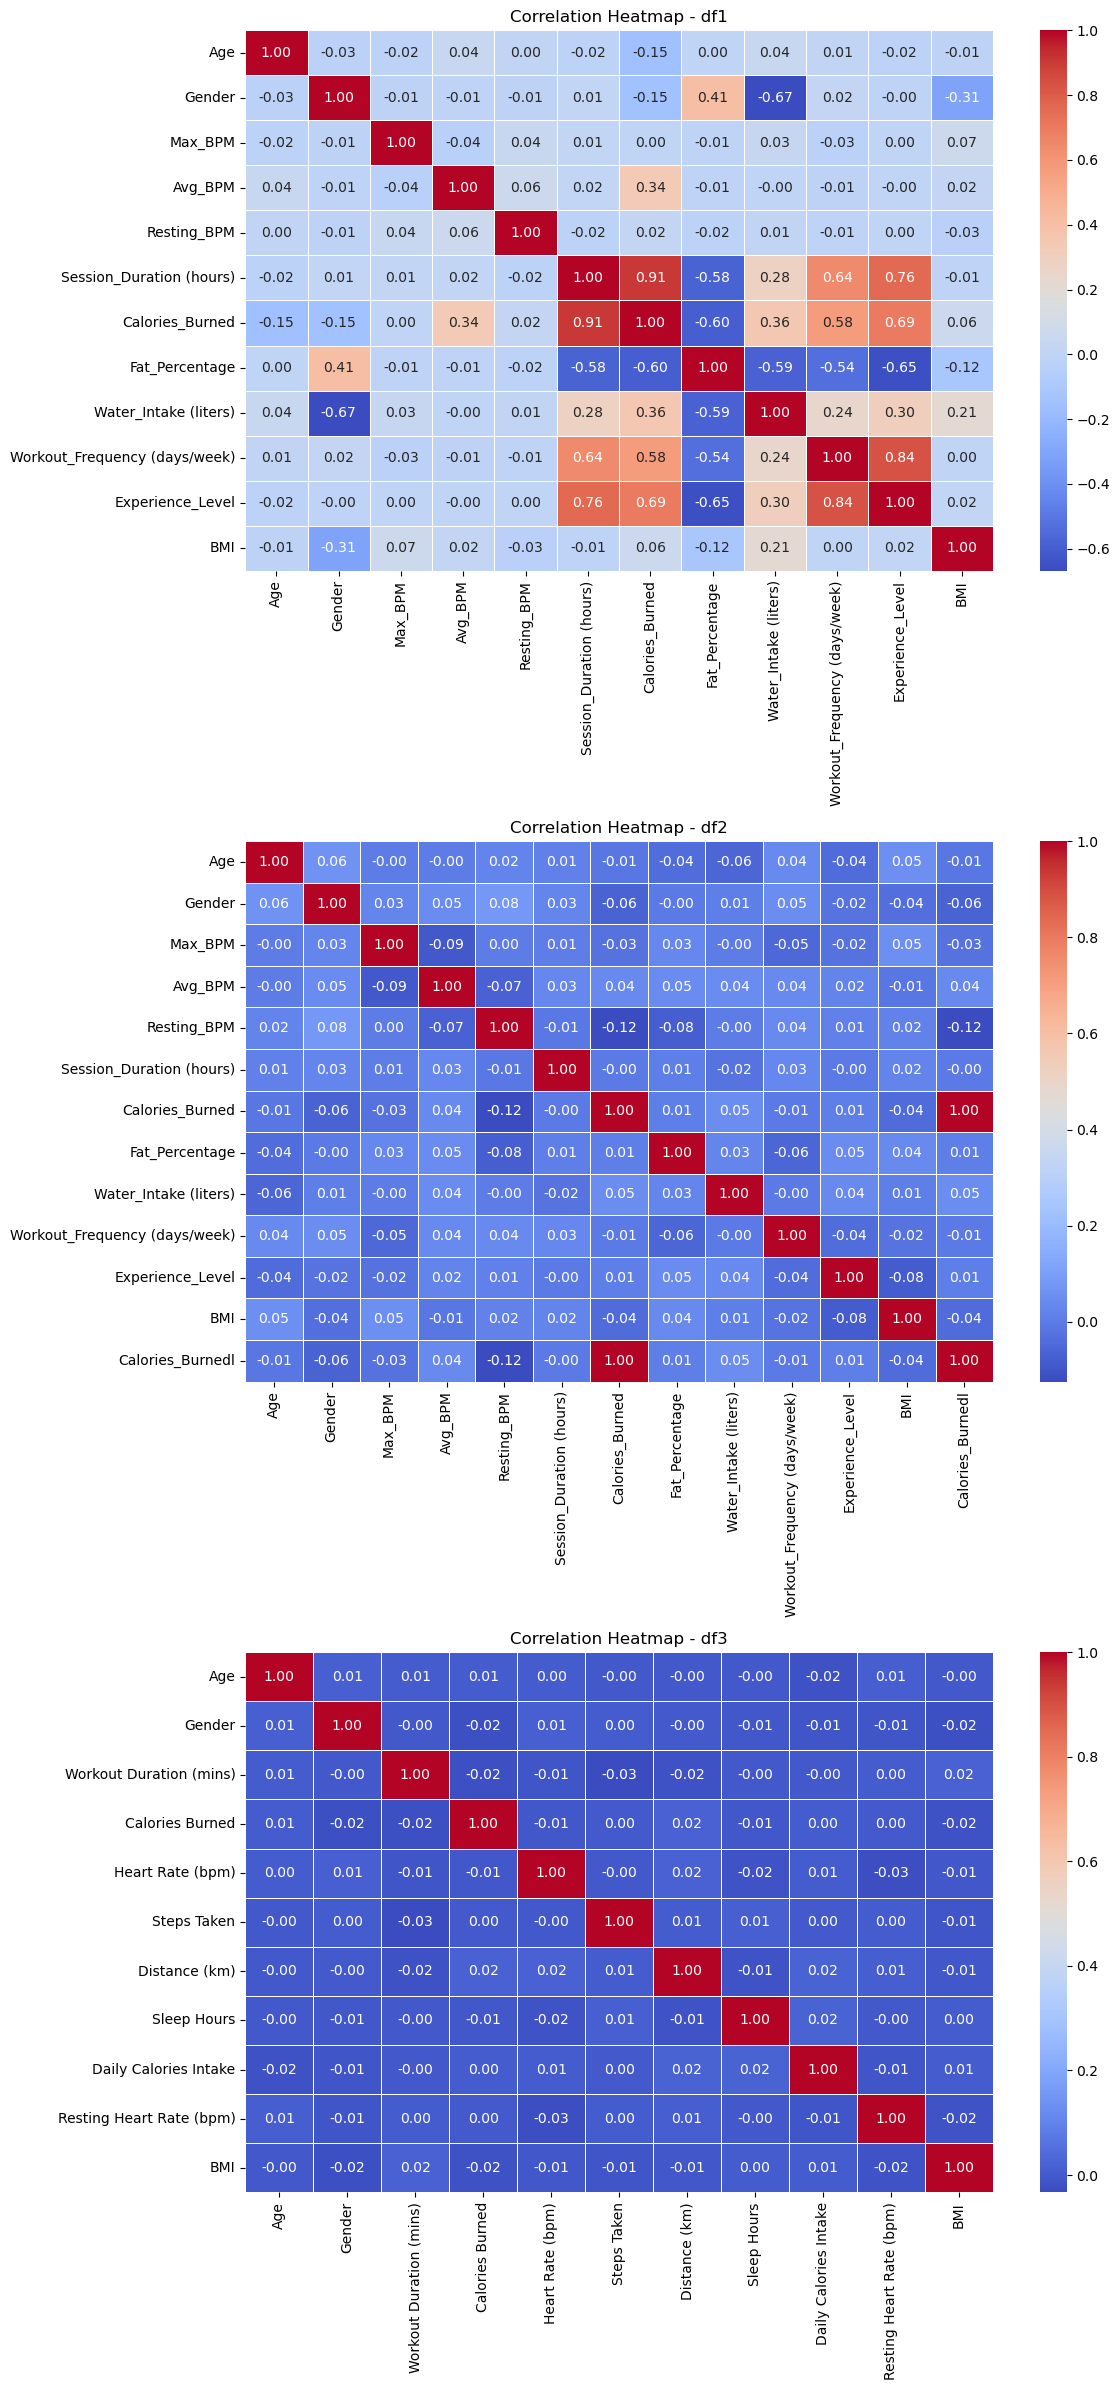

In [7]:
# Compute correlation matrices
correlation_matrix1 = df1.corr()
correlation_matrix2 = df2.corr()
correlation_matrix3 = df3.corr()

# Set up the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(12, 24))  # 1 row, 3 columns

# Heatmap for df1
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap - df1')

# Heatmap for df2
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap - df2')

# Heatmap for df3
sns.heatmap(correlation_matrix3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[2])
axes[2].set_title('Correlation Heatmap - df3')

# Adjust layout
plt.tight_layout()
plt.show()

## Split Data for Training

In [8]:
X1, y1 = df1.drop(columns="Calories_Burned"), df1["Calories_Burned"]
X2, y2 = df2.drop(columns="Calories_Burned"), df2["Calories_Burned"]
X3, y3 = df3.drop(columns="Calories Burned"), df3["Calories Burned"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

for i in [1, 2, 3]:
    exec(f"X_train_{i} = X_train_{i}.dropna(); y_train_{i} = y_train_{i}[X_train_{i}.index]")
    exec(f"X_test_{i} = X_test_{i}.dropna(); y_test_{i} = y_test_{i}[X_test_{i}.index]")

print(f"Dataset1: {X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape}")
print(f"Dataset2: {X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape}")
print(f"Dataset3: {X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape}")

Dataset1: ((778, 11), (195, 11), (778,), (195,))
Dataset2: ((1079, 12), (272, 12), (1079,), (272,))
Dataset3: ((5286, 10), (1322, 10), (5286,), (1322,))


## FNN

In [9]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()

        # First fully connected (dense) layer
        # Takes input_size features (14–17 from our datasets) and outputs 64 neurons
        # 64 neurons give the model enough capacity to learn complex patterns
        self.fc1 = nn.Linear(input_size, 64)

        # First ReLU activation introduces non-linearity
        self.relu1 = nn.ReLU()

        # Second dense layer reduces the dimensionality to 32 neurons
        # Helps compress learned representations and reduce overfitting
        self.fc2 = nn.Linear(64, 32)

        # Second ReLU activation to maintain non-linearity
        self.relu2 = nn.ReLU()

        # Final output layer that maps 32 features to 1 output
        # Regression task, so we output a single continuous value: predicted calories burned
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        # Pass input through first dense layer and activation
        out = self.relu1(self.fc1(x))

        # Pass result through second dense layer and activation
        out = self.relu2(self.fc2(out))

        # Final output layer gives the predicted calorie value
        return self.fc3(out)


## Training function

In [10]:
def train_fnn(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert the NumPy arrays into PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    # Convert y_train into a tensor and reshape it to be a 2D column vector
    y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    # Create a dataset and data loader for mini-batch training
    train_dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffling helps generalization

    # Initialize the FNN model using the number of input features
    model = FNN(X_train.shape[1])  
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Mean Squared Error loss is suitable for regression
    criterion = nn.MSELoss()

    train_losses = []  # To keep track of loss values over epochs

    for epoch in range(50):
        epoch_loss = 0  # Sum of losses for this epoch

        # Loop over each mini-batch
        for xb, yb in loader:
            pred = model(xb)                # Forward pass: predict using current model
            loss = criterion(pred, yb)      # Compute loss between predicted and actual
            optimizer.zero_grad()          # Reset gradients from previous step
            loss.backward()                # Backpropagation: compute gradients
            optimizer.step()               # Update weights based on gradients

            epoch_loss += loss.item()      # Add batch loss to epoch total

        # Compute average loss for this epoch
        avg_loss = epoch_loss / len(loader)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Generate predictions on the test set (no gradient tracking needed)
    with torch.no_grad():
        preds = model(X_test).numpy()

    # Return predicted test values and list of training losses
    return preds, train_losses



In [11]:
y_pred_1, losses_1 = train_fnn(X_train_1, y_train_1, X_test_1)
y_pred_2, losses_2 = train_fnn(X_train_2, y_train_2, X_test_2)
y_pred_3, losses_3 = train_fnn(X_train_3, y_train_3, X_test_3)

Epoch 1, Loss: 889853.1075
Epoch 2, Loss: 889265.1800
Epoch 3, Loss: 880349.1425
Epoch 4, Loss: 871149.2475
Epoch 5, Loss: 854064.9175
Epoch 6, Loss: 818591.2575
Epoch 7, Loss: 775537.5275
Epoch 8, Loss: 714934.1350
Epoch 9, Loss: 641496.7462
Epoch 10, Loss: 556303.0537
Epoch 11, Loss: 458271.4050
Epoch 12, Loss: 364347.4375
Epoch 13, Loss: 281953.0456
Epoch 14, Loss: 215069.3356
Epoch 15, Loss: 162548.4291
Epoch 16, Loss: 131524.9803
Epoch 17, Loss: 107069.7269
Epoch 18, Loss: 91683.2434
Epoch 19, Loss: 81888.8748
Epoch 20, Loss: 74004.0591
Epoch 21, Loss: 65687.4539
Epoch 22, Loss: 59633.6936
Epoch 23, Loss: 53596.9163
Epoch 24, Loss: 49729.3240
Epoch 25, Loss: 44781.6227
Epoch 26, Loss: 40178.1947
Epoch 27, Loss: 36670.2261
Epoch 28, Loss: 33510.6530
Epoch 29, Loss: 30799.3270
Epoch 30, Loss: 28041.6960
Epoch 31, Loss: 25778.1975
Epoch 32, Loss: 23909.1300
Epoch 33, Loss: 21657.4395
Epoch 34, Loss: 20219.9017
Epoch 35, Loss: 18802.7707
Epoch 36, Loss: 17260.4047
Epoch 37, Loss: 1613

In [12]:
mae_1 = mean_absolute_error(y_test_1, y_pred_1)
mae_2 = mean_absolute_error(y_test_2, y_pred_2)
mae_3 = mean_absolute_error(y_test_3, y_pred_3)

mse_1 = mean_squared_error(y_test_1, y_pred_1)
mse_2 = mean_squared_error(y_test_2, y_pred_2)
mse_3 = mean_squared_error(y_test_3, y_pred_3)

r2_1 = r2_score(y_test_1, y_pred_1)
r2_2 = r2_score(y_test_2, y_pred_2)
r2_3 = r2_score(y_test_3, y_pred_3)

print(f"Dataset1: mae_score: {mae_1} mse_score: {mse_1} r2_score: {r2_1}")
print(f"Dataset2: mae_score: {mae_2} mse_score: {mse_2} r2_score: {r2_2}")
print(f"Dataset3: mae_score: {mae_3} mse_score: {mse_3} r2_score: {r2_3}")

Dataset1: mae_score: 80.79869431715746 mse_score: 10925.031679289898 r2_score: 0.8690437120594983
Dataset2: mae_score: 70.71213520274443 mse_score: 7674.323798638183 r2_score: 0.9252511828278612
Dataset3: mae_score: 224.74425475427856 mse_score: 68078.58884081781 r2_score: -0.02745234966278076


In [13]:
for actual, pred in zip(y_test_1.values[:10], y_pred_1.flatten()[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")

Actual: 929.00, Predicted: 707.56
Actual: 1401.00, Predicted: 1487.46
Actual: 925.00, Predicted: 902.16
Actual: 1155.00, Predicted: 1157.81
Actual: 1587.00, Predicted: 1617.21
Actual: 1247.00, Predicted: 1341.13
Actual: 950.00, Predicted: 862.20
Actual: 927.00, Predicted: 735.56
Actual: 1053.00, Predicted: 1027.59
Actual: 1201.00, Predicted: 1219.27


In [14]:
for actual, pred in zip(y_test_2.values[:10], y_pred_2.flatten()[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")

Actual: 931.00, Predicted: 802.74
Actual: 1188.00, Predicted: 1072.16
Actual: 1262.00, Predicted: 1210.87
Actual: 1249.00, Predicted: 1317.87
Actual: 1355.00, Predicted: 1347.28
Actual: 698.00, Predicted: 631.86
Actual: 1392.00, Predicted: 1369.74
Actual: 1783.00, Predicted: 1808.03
Actual: 1272.00, Predicted: 1195.73
Actual: 1474.00, Predicted: 1458.08


In [15]:
for actual, pred in zip(y_test_3.values[:10], y_pred_3.flatten()[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")

Actual: 443.00, Predicted: 551.05
Actual: 912.00, Predicted: 580.56
Actual: 849.00, Predicted: 599.65
Actual: 809.00, Predicted: 519.56
Actual: 940.00, Predicted: 557.24
Actual: 371.00, Predicted: 613.56
Actual: 423.00, Predicted: 580.60
Actual: 383.00, Predicted: 562.67
Actual: 631.00, Predicted: 510.89
Actual: 597.00, Predicted: 617.66


## Data Visualization

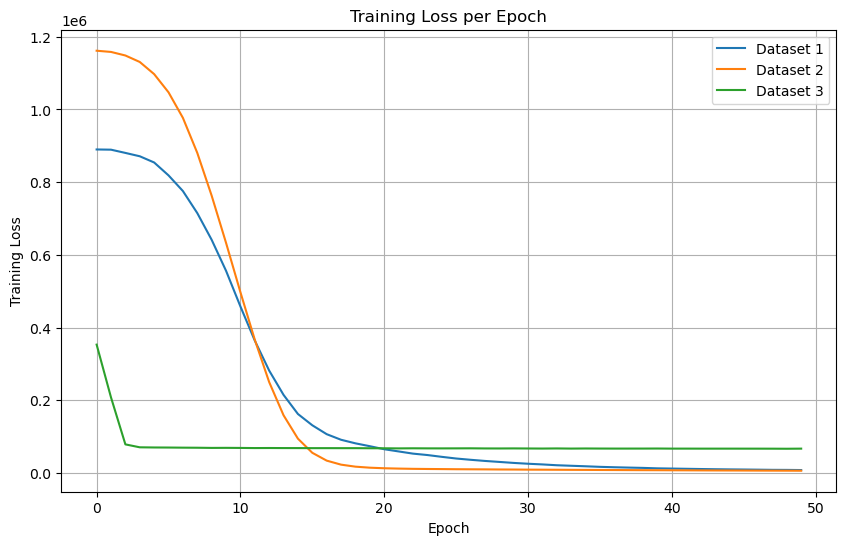

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(losses_1, label="Dataset 1")
plt.plot(losses_2, label="Dataset 2")
plt.plot(losses_3, label="Dataset 3")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

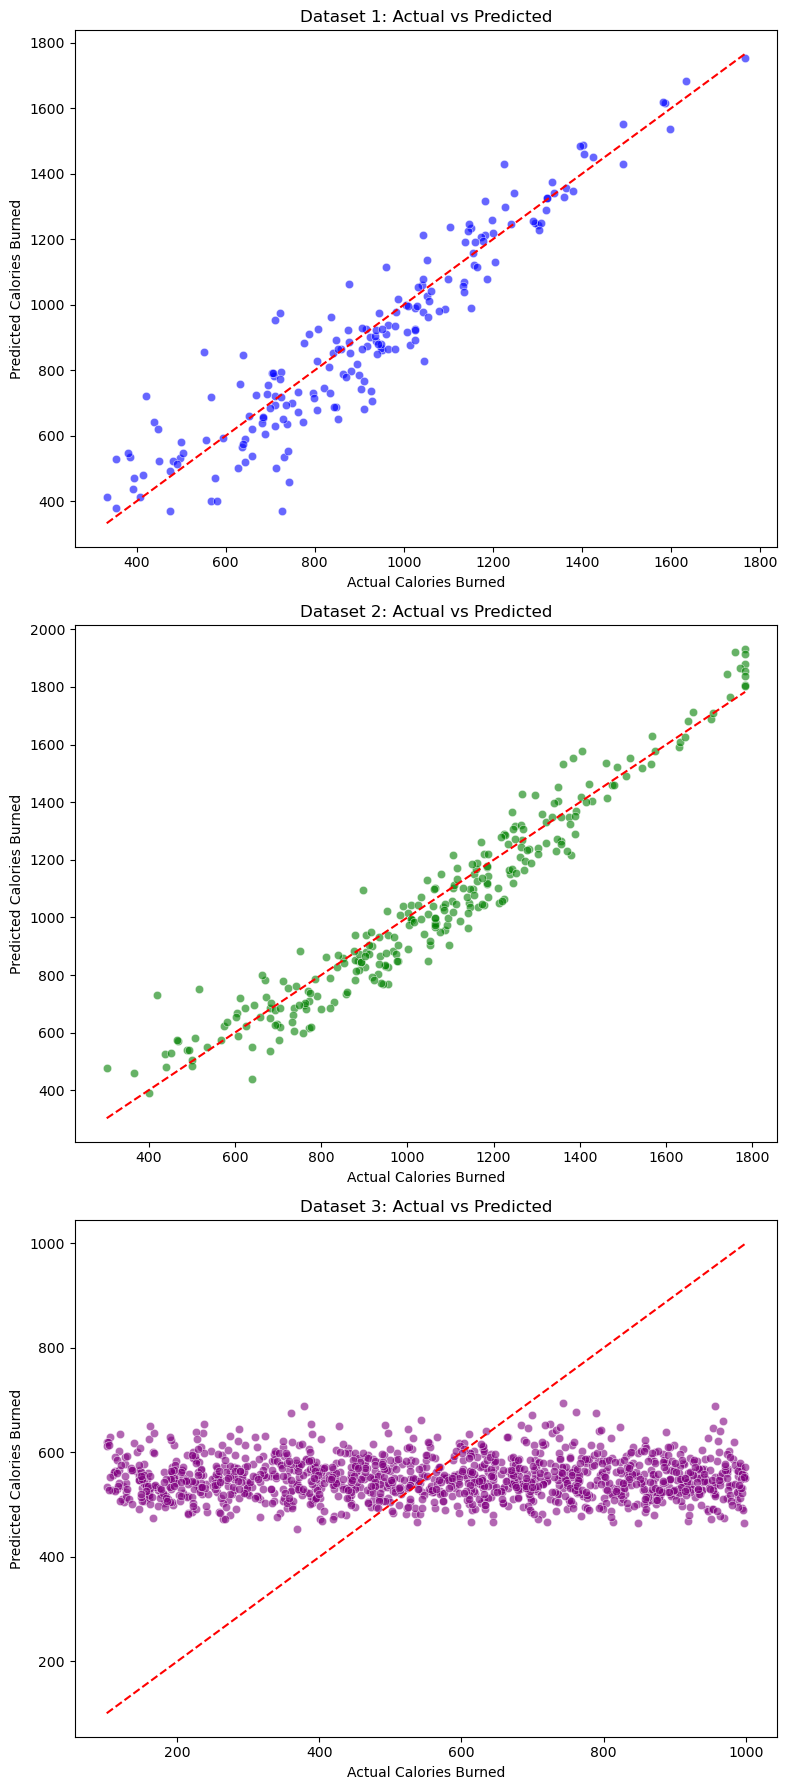

In [17]:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))

# Scatter plot for Dataset 1
sns.scatterplot(x=y_test_1, y=y_pred_1.flatten(), ax=axes[0], color="blue", alpha=0.6)
axes[0].plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], color='red', linestyle='--')
axes[0].set_title("Dataset 1: Actual vs Predicted")
axes[0].set_xlabel("Actual Calories Burned")
axes[0].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 2
sns.scatterplot(x=y_test_2, y=y_pred_2.flatten(), ax=axes[1], color="green", alpha=0.6)
axes[1].plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red', linestyle='--')
axes[1].set_title("Dataset 2: Actual vs Predicted")
axes[1].set_xlabel("Actual Calories Burned")
axes[1].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 3
sns.scatterplot(x=y_test_3, y=y_pred_3.flatten(), ax=axes[2], color="purple", alpha=0.6)
axes[2].plot([min(y_test_3), max(y_test_3)], [min(y_test_3), max(y_test_3)], color='red', linestyle='--')
axes[2].set_title("Dataset 3: Actual vs Predicted")
axes[2].set_xlabel("Actual Calories Burned")
axes[2].set_ylabel("Predicted Calories Burned")

plt.tight_layout()
plt.show()